### Supervised Learning-Classification
### Implementing Naive Bayes and K-Nearest Neighbor Algorithms

In [13]:
import pandas as pd 
import numpy as np

In [14]:
data = pd.read_csv('Titanic.csv')

In [15]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
data['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

### Data Preprocessing and Visualization

In [18]:
import seaborn as sns

<Axes: xlabel='Sex', ylabel='count'>

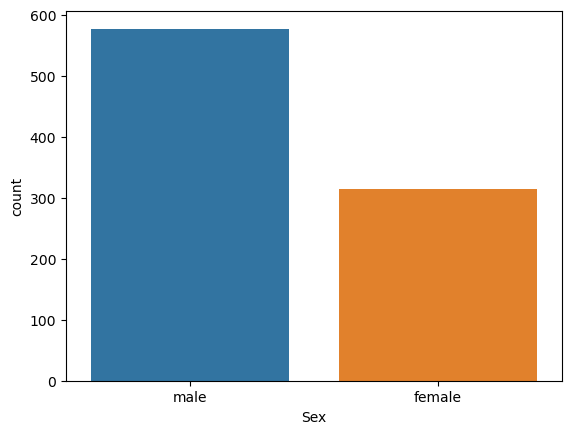

In [19]:
sns.countplot(x='Sex', data=data)

In [20]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Filling missing Age values with Median Age

In [22]:
data['Age'].fillna(data['Age'].median(), inplace=True)

#### Encoding Sex and Embarked Columns

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [25]:
data['Sex'] = le.fit_transform(data['Sex'])

In [26]:
data['Embarked'] = le.fit_transform(data['Embarked'])

In [27]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,2
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,28.0,1,2,W./C. 6607,23.4500,NaN,2
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,0


In [28]:
x = data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]
y = data['Survived']

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [36]:
X_train_np = X_train.astype(float).values
X_test_np = X_test.astype(float).values
y_train_np = Y_train.values
y_test_np = Y_test.values


### Naive-Bayes Algorithm

In [38]:
def naive_bayes_train(X, y):
    classes = np.unique(y)
    summaries = {}

    for c in classes:
        X_c = X[y == c]
        summaries[c] = {
            "mean": X_c.mean(axis=0),
            "var": X_c.var(axis=0) + 1e-9,  # add epsilon to avoid divide-by-zero
            "prior": X_c.shape[0] / X.shape[0]
        }
    return summaries

def gaussian_prob(x, mean, var):
    exponent = np.exp(- ((x - mean) ** 2) / (2 * var))
    return (1 / np.sqrt(2 * np.pi * var)) * exponent

def naive_bayes_predict(X, summaries):
    y_pred = []
    for x in X:
        posteriors = {}
        for c, params in summaries.items():
            prior = np.log(params["prior"])
            likelihood = np.sum(np.log(gaussian_prob(x, params["mean"], params["var"])))
            posteriors[c] = prior + likelihood
        y_pred.append(max(posteriors, key=posteriors.get))
    return np.array(y_pred)

nb_model = naive_bayes_train(X_train_np, y_train_np)
nb_predictions = naive_bayes_predict(X_train_np, nb_model)
train_accuracy = (nb_predictions == y_train_np).mean()
print(f"Naive Bayes Training Accuracy: {train_accuracy * 100:.2f}%")

# Test accuracy
nb_test_predictions = naive_bayes_predict(X_test_np, nb_model)
test_accuracy = (nb_test_predictions == y_test_np).mean()
print(f"Naive Bayes Test Accuracy: {test_accuracy * 100:.2f}%")

Naive Bayes Training Accuracy: 78.23%
Naive Bayes Test Accuracy: 78.77%


### K-Nearest Neighbors

In [60]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def knn_predict(X_train, y_train, X_test, k=5):
    predictions = []
    for x in X_test:
        distances = [euclidean_distance(x, x_train) for x_train in X_train]
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_indices]
        values, counts = np.unique(k_nearest_labels, return_counts=True)
        predictions.append(values[np.argmax(counts)])
    return np.array(predictions)

knn_preds = knn_predict(X_train_np, y_train_np, X_test_np, k=5)
knn_accuracy = (knn_preds == y_test_np).mean()
print(f"KNN Training Accuracy (k=5): {knn_accuracy * 100:.2f}%")

KNN Training Accuracy (k=5): 69.83%


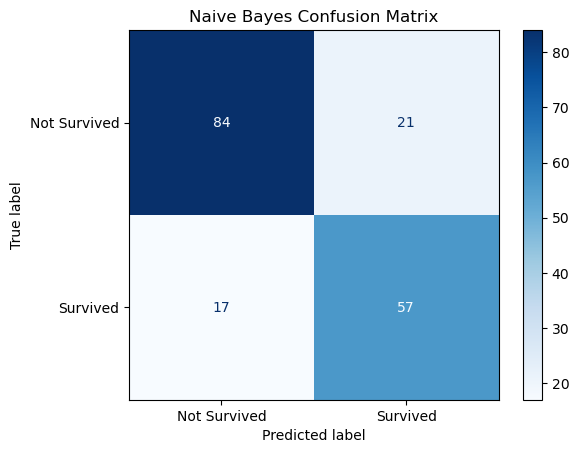

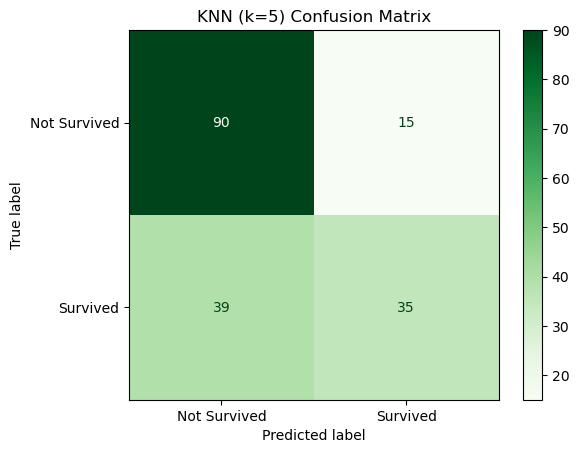

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Naive Bayes Confusion Matrix
nb_cm = confusion_matrix(y_test_np, nb_test_predictions)
nb_disp = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=["Not Survived", "Survived"])
nb_disp.plot(cmap=plt.cm.Blues)
plt.title("Naive Bayes Confusion Matrix")
plt.show()

# KNN Confusion Matrix
knn_cm = confusion_matrix(y_test_np, knn_preds)
knn_disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=["Not Survived", "Survived"])
knn_disp.plot(cmap=plt.cm.Greens)
plt.title("KNN (k=5) Confusion Matrix")
plt.show()
